# Introduction 

The goal of this project is to analyse et study the Enron email dataset available publicly in this __[link](http://www.aueb.gr/users/ion/data/enron-spam)__. 
<br>

The dataset is a collection of public domain emails from the Enron corporation. The emails have been manually classified as spam and non-spam. The primary goal of the project is to create a supervised classification pipeline to classify emails as spam or non-spam from the training data. The preprocessed emails of this dataset are used in this study. The preprocessed subdirectory contains the messages in the preprocessed format that was used in the experiments of this paper: 
*V. Metsis, I. Androutsopoulos and G. Paliouras, "Spam Filtering with Naive Bayes - Which Naive Bayes?". 
Proceedings of the 3rd Conference on Email and Anti-Spam (CEAS 2006), Mountain View, CA, USA, 2006.*
<br>

The data comes organised in six folders, each have inside one folder for spam emails and another for non-spam (referred to as ham as well). For ease of use, all emails have been collected in two folders, one for spam and one for non-spam.
Initial step consisted in data processing, inclduding cleaning data, removing stops words... This step have been reviewed couple of times after gathering further information about the dataset during Exploratory data analysis step and the preprocessing have been set based on these observations. Only training data subset have been used in defining this step.

Next, techniques of Bag of Words and TF-IDF have been presented, defined and applied to dataset prior to modelling steps in order to extract the most suitable parameters. Once these parameters (features) have been extracted from dataset, several categorisation models (classifiers) has been defined, parameters tuned and trained on train dataset. The performance of these different classifiers have been compared with the purpose of selecting the most optimal model to classify these emails.
Finally, the selected model has been applied to test subset and their performance presented.
<br>

Note: This report was generated from IPython Notebook with the purpose of making the project easier to follow thus it is including all functions. Comments are made both at paragraph level and within code.

## List of libraries used in this project

In [1]:
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import collections
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib
import seaborn as sns
%matplotlib inline
import csv
import re
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
import pickle


# Pre-processing

Pre-processing has been divided in three steps:
- Data collection: reading data from hard drive
- Splitting data to training and test subsets
- Data cleansing

## Data collection


In [2]:
#reading ham emails and creating dataframe ham (non-spam = 0)
path_ham = 'C:/Users/abenazou/Documents/Personal_data/IOT/EE514/Assignement/enron/pre/All/ham/*.txt'
ham_files = glob.glob(path_ham)
list_ham = []
for file_path in ham_files:
    with open(file_path) as f:
        list_ham.append(f.read())

ham= pd.DataFrame(list_ham, columns=["emails"])
ham["target"]= 0
        
#reading spam emails and creating dataframe spam (=1)
path_spam = 'C:/Users/abenazou/Documents/Personal_data/IOT/EE514/Assignement/enron/pre/All/spam/*.txt'
spam_files = glob.glob(path_spam)
list_spam = []
for file_path in spam_files:
    with open(file_path, encoding="Latin-1") as f:
        list_spam.append(f.read())
        
spam= pd.DataFrame(list_spam, columns=["emails"])
spam["target"]= 1

In [3]:
spam.head() #quick observation of top rows of spam DataFrame

,emails,target
0,Subject: fw : this is the solution i mentioned...,1
1,Subject: fw : this is the solution i mentioned...,1
2,Subject: adv : space saving computer to replac...,1
3,"Subject: advs\ngreetings ,\ni am benedicta lin...",1
4,Subject: fw : account over due wfxu ppmfztdtet...,1


Once the emails and their targets are loaded in the notebook, the next step consist on merging all data, shuffling it and creating Training and Test splits. The data has been also checked to not have empty emails (duplicate emails were already removed and not part of preproccessed data) 

## Training and test splits

In [4]:
#merging both datasets
allEmails=pd.concat([spam, ham])
allEmails = allEmails.sample(frac=1).reset_index(drop=True) # shuffling rows

#splitting data using train_test_split from sklearn, setting split at 70%/30%
X_train, X_test, y_train, y_test = train_test_split(allEmails['emails'],allEmails['target'],test_size=0.3, random_state=11)

Saving Training and test dat sets in csv files

In [5]:
# joing X_train and y_train
train_set = pd.concat([X_train, y_train], axis=1, join_axes=[X_train.index]) 
# saving training data into file "train_data.csv"
train_set.to_csv("train_data.csv", sep='\t', encoding='utf-8',index=False) 
# joing X_test and y_test
test_set = pd.concat([X_test, y_test], axis=1, join_axes=[X_test.index]) 
# saving test data into file "test_data.csv"
test_set.to_csv("test_data.csv", sep='\t', encoding='utf-8',index=False)

In [6]:
np.where(pd.isnull(allEmails)) # checking for null values

(array([], dtype=int64), array([], dtype=int64))

In [7]:
np.where(allEmails.applymap(lambda x: x == '')) # checking for empty emails

(array([], dtype=int64), array([], dtype=int64))

In [8]:
#Some statistics on the Training and Test data set
X_test.size # as expected 30% of data is set as Test data

10115

In [9]:
y_test.mean() # 51% of test data is spam emails while 49% is non-spam emails 

0.508353929807217

In [10]:
#Similar result observed with  Training set
y_train.mean()

0.5096817931443582

Using __[WordCloud library](https://github.com/amueller/word_cloud)__, a code is developped to generate a quick look at the common words in the spam dataset

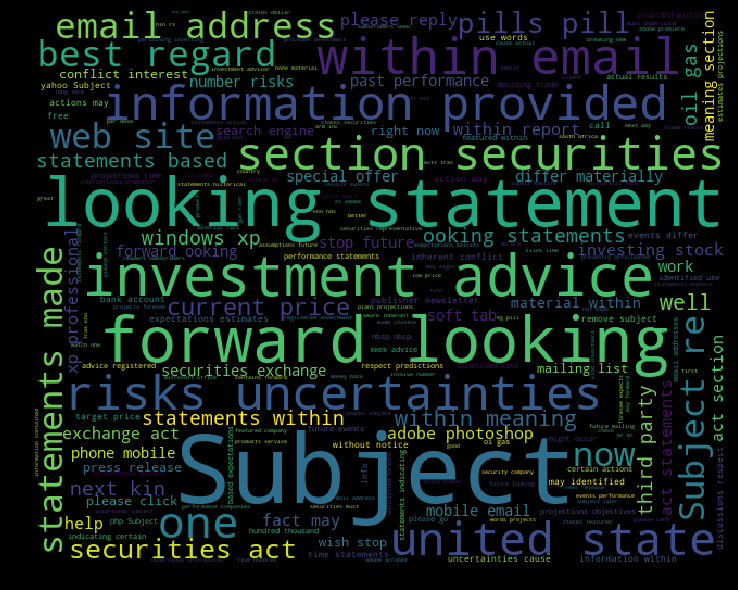

In [11]:
all_spam_words= ' '.join(train_set[train_set['target']==1]['emails']) # collecting all words
spam_figure= WordCloud(width=640, height=512).generate(all_spam_words)
plt.figure(figsize=(12,8), facecolor='black')
plt.imshow(spam_figure)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

It is clear from observing the figure above that:
- words such as "Subject" "best regards" are most seen word as expected. Since those kind of words exist in pretty much all email (spam and ham), it would be useful to remove ehese words at the following cleansing step.
- Some of the dominant and expected words are: special, offer, free, investment, advice.

## Data Cleansing

From this part and until __Model Evaluation__ step at the end, the only data that will be used is the Training dataset.
First part of feature extraction step consists in cleaning the data by applying the following approaches:
- Lemmatization/ tokenization
- stop word removal: this consist on removing common words such as 'the' 'a' 'and' 'of' which if left can lead to ...
<br>

Two other steps of cleansing: Removing capital letters and Tokenization (splitting emails into words and removing punctuation) will applied as part of the next step (bag of words). It has to be noted that all these cleansing steps need to be applied to test data during model evaluation part.

### Data cleansing process

In [12]:
stop_words= set(stopwords.words('english'))
newStopWords = {'subject','dear','best regards','looking forward','forward','looking',
                'email','email address','re','re:','fw','_'}
stop_word= stop_words.union(newStopWords)

In [13]:
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

def lemmatize_email(text):
    return [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)]

X_train_lemmatized = X_train.apply(lemmatize_email)

X_train_processed= X_train_lemmatized.apply(lambda x: ' '.join([word for word in x if word.lower() not in (stop_word)]))

In [14]:
#creating dataframe train_set_processed 
train_set_processed = pd.concat([X_train_processed, y_train], axis=1, join_axes=[X_train_processed.index])
train_set_processed.columns = ['emails', 'target']

### Feature extraction

Once the data has been cleaned and processed, the next step is to extract and select features that will be used to construct prediction models. Two techniques will be implemented to extract these features:
1. "Bag of words"
2. TF-IDF
<br>

Bag of words technique consist on finding the frequency or probability of occurrence of each word in the dataset aka email. In the other hand, TF-IDF or Term Frequency-Inverse Document Frequency is, as it it name mention, the technique of computing in addition for each word or feature the Inverse Document Frequency. That's mean a word that occurs a lot is not that important and gives less information as feature for the model. Tf-idf vectors are usually long (up to 50,000) and sparse.

The two technique swill be applied on the cleansed data and the resulting "vectors" will be used to train and select the optimum Supervised classification model.

#### Bag of Words

In order to apply tradionnal Bag of Words approach, CountVectorizer()from sklearn library is applied to transform and change data to a vocabulary of unique words with a unique identifier assigned for each word

In [15]:
bOw_vectorizer = CountVectorizer(min_df=5, ngram_range=(1,2), analyzer='char_wb')
Xvec_BoW = bOw_vectorizer.fit_transform(np.array(X_train_processed))
Xvec_BoW.shape

(23601, 1140)

The following routine gives a view of Bag of words vectorizer matrix containing the sparse feature vectors. The rows are the number of emails and the columns represent the unique ids of the words in constructed vocabulary. Each cell features the raw term frequencies $tf(w,e)$ which are the number of times a word w appears in an email e.

In [16]:
feature_vectors_matrix_BoW = Xvec_BoW.toarray()
print(feature_vectors_matrix_BoW)

[[ 150    0    1 ...    0    0    0]
 [ 114    0    0 ...    0    0    0]
 [  30    0    2 ...    0    0    0]
 ...
 [ 162    0    2 ...    0    0    0]
 [ 108    0    0 ...    0    0    0]
 [1058    2    1 ...    0    0    0]]


#### Term Frequency - Inverse Document Frequency<b>

The purpose of applying TF-IDF is to reduce weights for words that occur in many documents in the corpus and are therefore bring less information that those that occur less. Using TfidfTransformer (sklearn), TF-IDF is computed as described by the following equations: 

$$ tf-idf(w,e) = tf(w,e) * (idf(w,e) + 1) $$<br>
with tf(w,e ), the number of times a word w appears in an email e
and $$ idf(w,e) = \frac{1 + n_e}{1 + df(e,w)}$$ with $n_e$ the total number of emails and df(e,w) the email-frequency which is number of emails e that contain the word w. 

The TfidfTransformer of sklearn takes the features of raw emails and convert to a matrix of TF-IDF  defined equations and by normalizing the data using the L2-normalization method.
<br>

**After few iterations min_df and ngram_range parameters of TfidfTransformer has been set at 5 and (1,2) respectively.** 
<br>
min_df= 5 means that a word to be considered as feature has to be repeated in the dataset for at least 5 times (helps to eliminate misspelled words for example). Features considered are either single token/ word or combination of two (if set at higher it was observed that the performance are not much better but the routine becomes much longer). It is well known in the literature that ngram_range higher that 5 is usually less performant than for values between 1 and 4.

In [17]:
Tfidf_vectorizer_p = TfidfVectorizer(min_df=5, ngram_range=(1,2), analyzer='char_wb').fit(X_train_processed)
Xvec_tfidf= Tfidf_vectorizer_p.transform(X_train_processed)

Features_names= np.array(Tfidf_vectorizer_p.get_feature_names())
Features_names.shape # length of TF-IDF vector

(1140,)

# Exploratory data analysis

In this section, some exploratory data analysis techniques will be applied to processed, aka cleansed, training dataset with purpose of understanding bit more about it and get more familiar with the dataset and gain insights into the kinds of features that can be useful for classification. The analysis will be extended to the two generated features set extracted in the previous part, Xvec_BoW and Xvec_tfidf.
<br>

The following data analysis and observation steps are presented:
- list of top-20 most frequently used words in spam and non-spam emails and bar plot to show their relative frequencies
- using boxplot, a comparison of the distribution of email lengths in spam and non-spam emails

## List of top-20 most frequently used words in spam emails

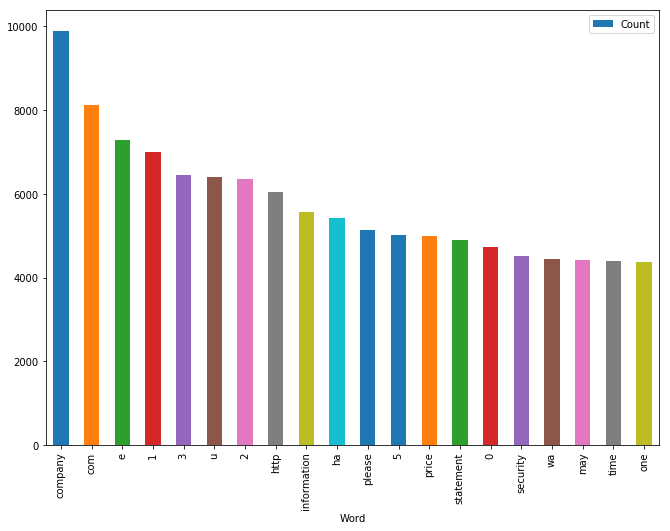

In [18]:
all_spam_wordsp= ' '.join(train_set_processed[train_set_processed['target']==1]['emails']) # collecting all words
Top_spam = collections.Counter(all_spam_wordsp.split()).most_common(20)
                                    
Top20_spam = pd.DataFrame(Top_spam, columns = ['Word', 'Count'])
matplotlib.rcParams['figure.figsize'] = 11, 8
Top20_spam.plot.bar(x='Word',y='Count')

In [19]:
Top20_spam.head()

,Word,Count
0,company,9898
1,com,8130
2,e,7277
3,1,7003
4,3,6445


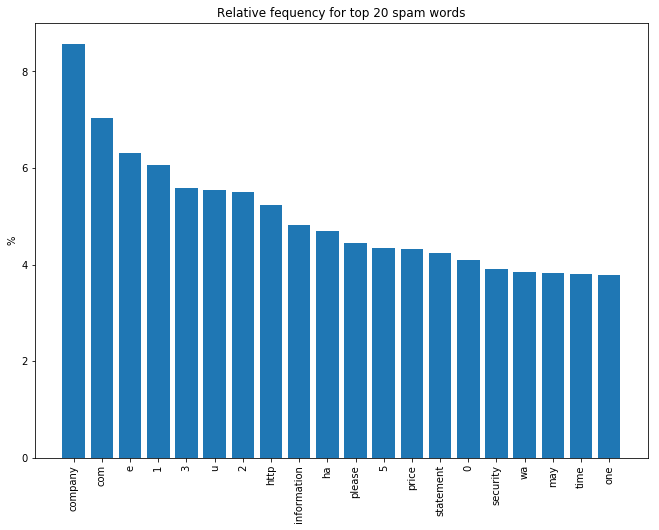

In [20]:
seriesspam = Top20_spam['Count'] / sum(Top20_spam['Count'])
indx = range(20)
plt.bar(indx, seriesspam*100)
plt.ylabel('%') 
plt.title('Relative fequency for top 20 spam words')
plt.xticks(indx, Top20_spam['Word'], rotation='vertical')
figsize=(800,600)

## List of top-20 most frequently used word in ham emails

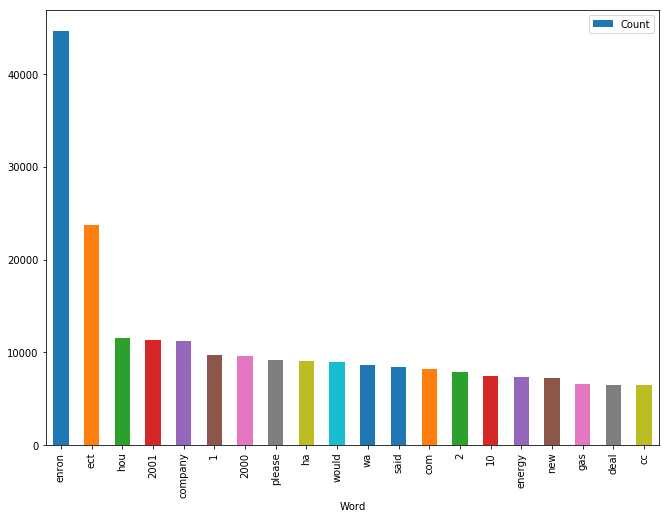

In [21]:
all_ham_wordsp= ' '.join(train_set_processed[train_set_processed['target']==0]['emails']) # collecting all words
Top_ham = collections.Counter(all_ham_wordsp.split()).most_common(20)
                                    
Top20_ham = pd.DataFrame(Top_ham, columns = ['Word', 'Count'])
matplotlib.rcParams['figure.figsize'] = 11, 8
Top20_ham.plot.bar(x='Word',y='Count')

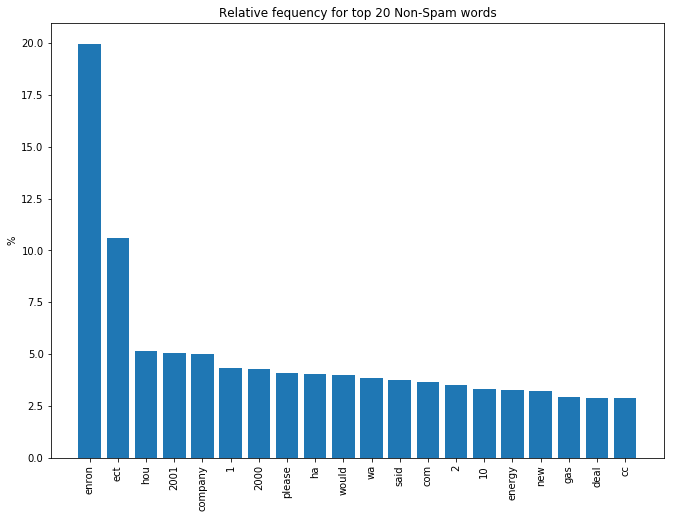

In [22]:
seriesham = Top20_ham['Count'] / sum(Top20_ham['Count'])
indx = range(20)
plt.bar(indx, seriesham*100)
plt.ylabel('%') 
plt.title('Relative fequency for top 20 Non-Spam words')
plt.xticks(indx, Top20_ham['Word'], rotation='vertical')
figsize=(800,600)

## Emails length

Compare the distribution of email lengths in spam and non-spam emails using appropriate plots 

In [23]:
train_set_processed['length']=train_set_processed['emails'].str.len()

conditions = [ train_set_processed['target']==1,train_set_processed['target']==0]
outputs = ['Spam','Non-Spam']
train_set_processed['class'] = np.select(conditions, outputs)

train_set_processed.head()

,emails,target,length,class
7427,tadalafil soft tab great result hi new product...,1,396,Spam
21998,online univeristy diploma degree n l n e u n v...,1,339,Spam
20922,hpl nom may 12 14 2001 see attached file hplno...,0,66,Non-Spam
16446,half prce wndows 2 ooo workstation mlcro soft ...,1,530,Spam
23944,fyi gas flow forwarded jackie young hou ect 04...,0,188,Non-Spam


Plotting distribution of email lengths in spam and non-spam emails. Second figure is with 'zooming'by restricting y axis to where distrubution of length of emails.

(0, 100000)

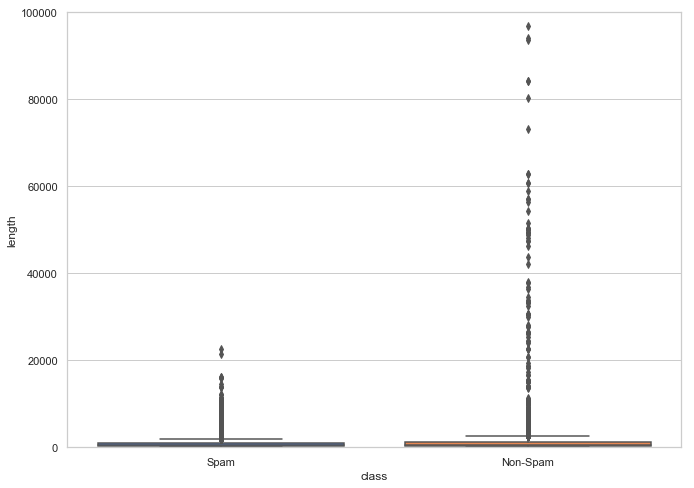

In [24]:
sns.set(context='notebook', style='whitegrid')
figsize=(11,8)
ax= sns.boxplot(x='class', y='length', palette= "muted",saturation= 0.9, data=train_set_processed)
ax.set_ylim([0, 100000])

(0, 3000)

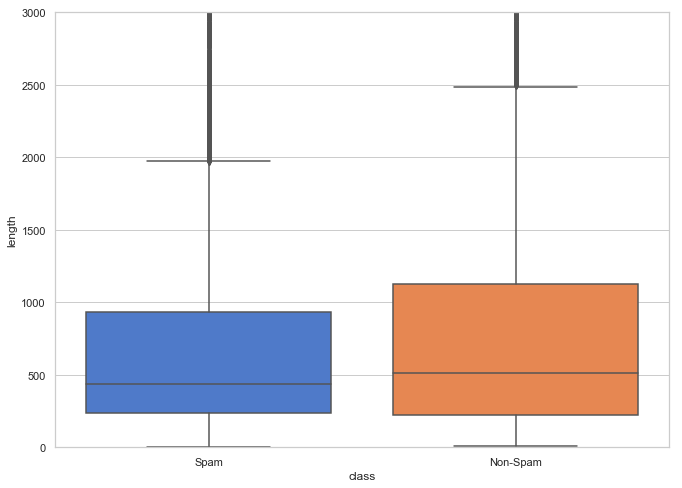

In [25]:
sns.set(context='notebook', style='whitegrid')
figsize=(11,8)
ax= sns.boxplot(x='class', y='length', palette= "muted",saturation= 0.9, data=train_set_processed)
ax.set_ylim([0, 3000])

As expected, figures confirm that spam emails are usually shorter than ham email. This is due mainly to:

- average length of non non-spam above 500 while average length for spam emails is below 500.
- non-spam email are usually full of relevant information and instructions about specific job task, meeting.. thus can contain my words
- non-spam emails are longer than spam email due principally to the fact that they contain usually back and four replies thus are most of the time the are containing actually the texts from many emails rather than just one email.

In [26]:
#Let's have look at the longest email
train_set_processed[train_set_processed['length']==train_set_processed['length'].max()]

,emails,target,length,class
9284,enron mention enron wake call wall street jour...,0,157606,Non-Spam


In [27]:
longest_email= train_set_processed.loc[24951,'emails']
collections.Counter(longest_email.split()).most_common(10)

[('air', 4),
 ('nt', 4),
 ('63', 2),
 ('vacation', 2),
 ('cruise', 2),
 ('hotel', 2),
 ('w', 2),
 ('china', 2),
 ('tour', 2),
 ('7', 2)]

As expected the longest email is a non-spam.

## Common words in the dataset after cleansing process

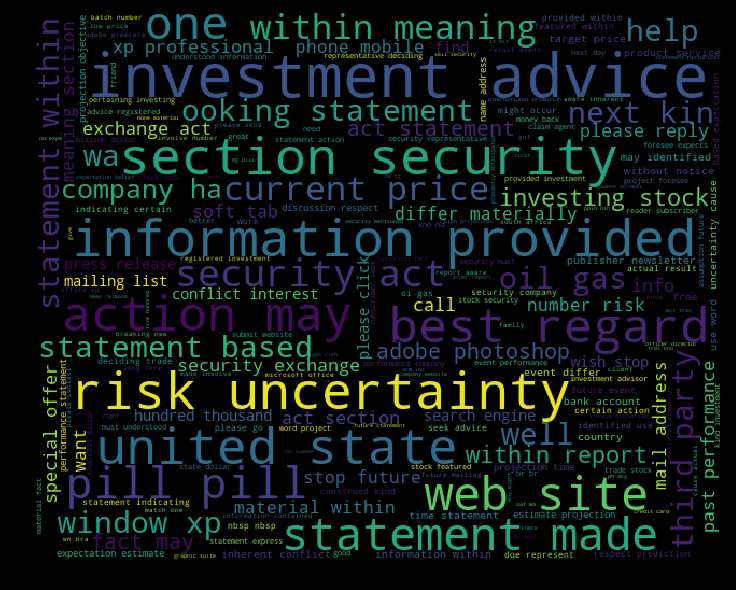

In [28]:
spam_figure= WordCloud(width=640, height=512).generate(all_spam_wordsp)
plt.figure(figsize=(12,8), facecolor='black')
plt.imshow(spam_figure)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

As expected words such as security, price pill, statement are dominant again

Let's apply the same with ham, non-spam data:

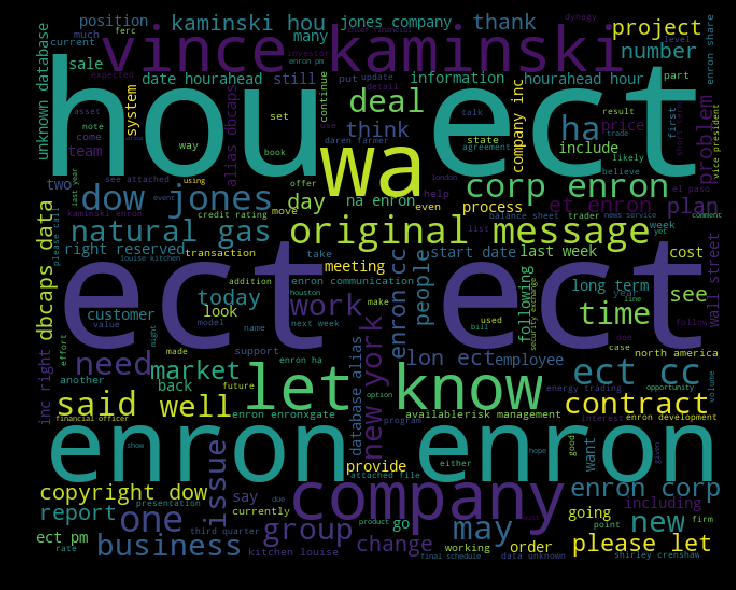

In [29]:
ham_figure= WordCloud(width=640, height=512).generate(all_ham_wordsp)
plt.figure(figsize=(12,8), facecolor='black')
plt.imshow(ham_figure)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

With non-spam set, the following words were dominat and repeated many time: company name: Enron, company, natural gas, Vincent Kaminski (director at Enron)

# Supervised Classification

In this step, a supervised classification model will be implemented and tested with training data for initial observation. The first part will consist in extracting a validation set from training then in the second part a multinomial Naive Bayes classifier will be fit to the remaining training data and tested with the validation data. 

## Extracting validation set

The idea is to divide the initial full set into three sets: Training set representing 50% of all data, Validation set representing 20% of data and final 30% are Testing set that were extracted previously.
In order to extract 50% of total Training set, a splitting of 71%/ 29% need to be applied on *train_set_processed* in ordet to create separate training and validations sets

In [30]:
#splitting data using train_test_split from sklearn, setting split at 71%/31%
X_training, X_val, y_training, y_val = train_test_split(train_set_processed['emails'],
                                                        train_set_processed['target'], test_size=0.29, random_state=9)

In [31]:
X_training[1:5]

5487     interconnect agreement fyi original message ra...
32992    eis invoice may wanted make aware message fina...
28419    confidentiality agreement paul thank taking ti...
22684    heas 2000 sporting clay tournament august 15 a...
Name: emails, dtype: object

## Traning and fitting a multinomial Naive Bayes classifier

### Multinomial Naive Bayes classifier with Bag of words

Using functions from sklearn library, a multinomial Naive Bayes classifier (feature extraction using Bag of words) is trained and fit to the data. Next, the model is applied to predit the target value for validation set

In [32]:
#Bag of words vectorizer fit to training data
BoW_vectorizer = CountVectorizer().fit(X_training)
Xvec_bow_train= BoW_vectorizer.transform(X_training)

# Multinomial Naive Bayes classifier defined and trained with training data then use dto predit y for training data
Multi_BoW= MultinomialNB(alpha=0.1)
Multi_BoW.fit(Xvec_bow_train,y_training)
y_training_pred_MultiBoW = Multi_BoW.predict(Xvec_bow_train)

# Bag of words vectorizer fit to validation data and classifier prediting y for validation data
Xvec_bow_val= BoW_vectorizer.transform(X_val)
y_val_pred_MultiBoW = Multi_BoW.predict(Xvec_bow_val)

Next step consists in evaluating performance of this MultinomialNB classifier using several performance metrics as defined in the sklearn.metrics package. The following metrics have been selected and will be investigated. The selection was based on te idea to cover all various error reading approaches by looking at parameters that combine several approaches.
- Confusion or Error Matrix
- Accuracy
- Recall or Sensitivity (True Positive Rate)
- Precision
- F1-Score
- Area under the receiver operating (ROC) curve (AUC)

In [33]:
print("Confusion or Error Matrix with validation set:")
print(confusion_matrix(y_val, y_val_pred_MultiBoW))
print("\n")

print("Quick calculation of Accuracy of model with training set:")
print(accuracy_score(y_training, y_training_pred_MultiBoW))
print("\n")

print("Accuracy of model with validation set:")
accuracy_Multi_BoW=accuracy_score(y_val, y_val_pred_MultiBoW)
print(accuracy_Multi_BoW)
print("\n")

print("Recall or Sensitivity(True Positive Rate) with validation set:")
print(recall_score(y_val, y_val_pred_MultiBoW))
print("\n")

print("Precision with validation set:")
print(precision_score(y_val, y_val_pred_MultiBoW))
print("\n")

print("F1-Score with validation set:")
F1_Multi_BoW=f1_score(y_val, y_val_pred_MultiBoW)
print(F1_Multi_BoW)
print("\n")

print("Area under the receiver operating (ROC) curve (AUC):")
print(roc_auc_score(y_val, y_val_pred_MultiBoW))

Confusion or Error Matrix with validation set:
[[3295   45]
 [  35 3470]]


Quick calculation of Accuracy of model with training set:
0.994031988541418


Accuracy of model with validation set:
0.9883126369612856


Recall or Sensitivity(True Positive Rate) with validation set:
0.9900142653352354


Precision with validation set:
0.9871977240398293


F1-Score with validation set:
0.9886039886039887


Area under the receiver operating (ROC) curve (AUC):
0.98827060572151


In [34]:
print("A summary report of previous measurements with validation set: (1 for spam)")
print(classification_report(y_val, y_val_pred_MultiBoW, digits=3)) #with validation set

A summary report of previous measurements with validation set: (1 for spam)
             precision    recall  f1-score   support

          0      0.989     0.987     0.988      3340
          1      0.987     0.990     0.989      3505

avg / total      0.988     0.988     0.988      6845



Saving model using pickle

In [35]:
# Saving classifier as a pickle file 
pickle.dump(Multi_BoW, open('Multi_BoW_model.sav', 'wb'))

Reading these statistics, the following can be concluded:
- Impressive result with validation dataset with an accuracy of 98%
- Number of spam emails classified correctly:3324 while Number of spam emails classified incorrectly:42
- Number of ham emails classified correctly:3443 while Number of ham emails classified incorrectly:36

Overall the results are not surprising as their are similar to what have been presented in the original paper of *Mitis et al.*

## Multinomial Naive Bayes classifier with TF-IDF

This time, a multinomial Naive Bayes classifier is trained and fit to the data using TF-IDF feature extracting method using the same parameters tested previousely. Next, the model is applied to predit the target value for validation set

In [36]:
#TF-IDF vectorizer fit to training data
Tfidf_vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1,2), analyzer='char_wb').fit(X_training)
Xvec_tfidf_train= Tfidf_vectorizer.transform(X_training)

# Multinomial Naive Bayes classifier defined and trained with training data then used to predit y for training data
Multi_Tfidf= MultinomialNB(alpha=0.1)
Multi_Tfidf.fit(Xvec_tfidf_train,y_training)
y_training_pred_tfidf = Multi_Tfidf.predict(Xvec_tfidf_train)

# TF-IDF vectorizer fit to validation data and classifier prediting y for validation data
Xvec_tfidf_val= Tfidf_vectorizer.transform(X_val)
y_val_pred_MultiTFIDF= Multi_Tfidf.predict(Xvec_tfidf_val)

Same as with Bag of Words, the MultinomialNB classifier is evaluated using same performance metrics defined above.

In [37]:
print("Confusion or Error Matrix with validation set:")
print(confusion_matrix(y_val, y_val_pred_MultiTFIDF))
print("\n")

print("Quick calculation of Accuracy of model with training set:")
print(accuracy_score(y_training, y_training_pred_tfidf))
print("\n")

print("Accuracy of model with validation set:")
print(accuracy_score(y_val, y_val_pred_MultiTFIDF))
print("\n")

print("Recall or Sensitivity(True Positive Rate) with validation set:")
print(recall_score(y_val, y_val_pred_MultiTFIDF))
print("\n")

print("Precision with validation set:")
print(precision_score(y_val, y_val_pred_MultiTFIDF))
print("\n")

print("F1-Score with validation set:")
print(f1_score(y_val, y_val_pred_MultiTFIDF))
print("\n")

print("Area under the receiver operating (ROC) curve (AUC):")
print(roc_auc_score(y_val, y_val_pred_MultiTFIDF))

Confusion or Error Matrix with validation set:
[[2489  851]
 [ 355 3150]]


Quick calculation of Accuracy of model with training set:
0.8241227023155885


Accuracy of model with validation set:
0.8238130021913805


Recall or Sensitivity(True Positive Rate) with validation set:
0.8987161198288159


Precision with validation set:
0.7873031742064484


F1-Score with validation set:
0.8393285371702637


Area under the receiver operating (ROC) curve (AUC):
0.8219628503335696


In [38]:
print("A summary report of previous measurements with validation set: (1 for spam)")
print(classification_report(y_val, y_val_pred_MultiTFIDF)) #with validation set

A summary report of previous measurements with validation set: (1 for spam)
             precision    recall  f1-score   support

          0       0.88      0.75      0.80      3340
          1       0.79      0.90      0.84      3505

avg / total       0.83      0.82      0.82      6845



In [39]:
# Saving classifier as a pickle file 
pickle.dump(Multi_Tfidf, open('Multi_tfidf_model.sav', 'wb'))

Reading these statistics, the results are below that those with Bag of words with a total accuracy with validation dataset of 82%. An explanation to this difference is that it is possible that the TF_IDF introducing too many hyperparameters thus leading to higher misclassification of emails.

# Model Selection 

In this step, and same as in the previous step, several supervised classification models will be implemented and tested with training data. The models will be fit to the training data and tested with the validation data.
In addition to a multinomial Naive Bayes classifier which was evaluated in previous section, the models that will evaluated here are the following:
- Logistic regression
- k-nearest neighbors
- Linear Support Vector Machines

Each model will be evaluated with features from Bag of Words approach and also from TF_IDF approaches and by varying some of the parameters (i.e. regularization coefficient).
<br>
**Note: Only a selection presented here (to keep report within 30 pages, other models and their code can be found at appendix at the end**

## Logistic regression (C=100)

### Logistic regression classifier (C=100) with Bag of words

Using funtions from sklearn library, a Logistic regression classifier (feature extraction using Bag of words) is trained and fit to the data. Next, the model is applied to predit the target value for validation set. Initially C, the Inverse of regularization strength is set at 100.

In [40]:
# Logistic regression classifier defined and trained with training data then used to predit y for training data
Lreg_BoW= LogisticRegression(C= 100)
Lreg_BoW.fit(Xvec_bow_train,y_training)
y_training_pred_LregBoW = Lreg_BoW.predict(Xvec_bow_train)

# classifier prediting y for validation data
y_val_pred_LregBoW = Lreg_BoW.predict(Xvec_bow_val)

Same as with MultinomialNB classifier, the performance of the model is evaluated same performance metrics.

In [41]:
print("Confusion or Error Matrix with validation set:")
print(confusion_matrix(y_val, y_val_pred_LregBoW))
print("\n")

print("Quick calculation of Accuracy of model with training set:")
print(accuracy_score(y_training, y_training_pred_LregBoW))
print("\n")

print("Accuracy of model with validation set:")
print(accuracy_score(y_val, y_val_pred_LregBoW))
print("\n")

print("Recall or Sensitivity(True Positive Rate) with validation set:")
print(recall_score(y_val, y_val_pred_LregBoW))
print("\n")

print("Precision with validation set:")
print(precision_score(y_val, y_val_pred_LregBoW))
print("\n")

print("F1-Score with validation set:")
print(f1_score(y_val, y_val_pred_LregBoW))
print("\n")

print("Area under the receiver operating (ROC) curve (AUC):")
print(roc_auc_score(y_val, y_val_pred_LregBoW))

Confusion or Error Matrix with validation set:
[[3265   75]
 [  34 3471]]


Quick calculation of Accuracy of model with training set:
1.0


Accuracy of model with validation set:
0.9840759678597516


Recall or Sensitivity(True Positive Rate) with validation set:
0.9902995720399429


Precision with validation set:
0.9788494077834179


F1-Score with validation set:
0.9845411998298114


Area under the receiver operating (ROC) curve (AUC):
0.9839222411097918


In [42]:
print("A summary report of previous measurements with validation set: (1 for spam)")
print(classification_report(y_val, y_val_pred_LregBoW, digits=3)) #with validation set

A summary report of previous measurements with validation set: (1 for spam)
             precision    recall  f1-score   support

          0      0.990     0.978     0.984      3340
          1      0.979     0.990     0.985      3505

avg / total      0.984     0.984     0.984      6845



In [43]:
# Saving classifier as a pickle file 
pickle.dump(Lreg_BoW, open('Lreg_BoW_model.sav', 'wb'))

Same as with MultinomialNB classifier, the performance of the model are very good and very similar as with Multi Bayes Naive classifier.

### Logistic regression classifier (C=100) with TF-IDF

This time, the Logistic regression model is trained and fit to the data using TF-IDF feature extracting method using the same parameters tested previousely. Next, the model is applied to predit the target value for validation set

In [44]:
# Logistic regression classifier defined and trained with training data then use dto predit y for training data
Lreg_Tfidf= LogisticRegression(C= 100)
Lreg_Tfidf.fit(Xvec_tfidf_train,y_training)
y_training_pred_tfidf_lreg = Lreg_Tfidf.predict(Xvec_tfidf_train)

# classifier prediting y for validation data
y_val_pred_LregTFIDF = Lreg_Tfidf.predict(Xvec_tfidf_val)

In [45]:
print("Confusion or Error Matrix with validation set:")
print(confusion_matrix(y_val, y_val_pred_LregTFIDF))
print("\n")

print("Quick calculation of Accuracy of model with training set:")
print(accuracy_score(y_training, y_training_pred_tfidf_lreg))
print("\n")

print("Accuracy of model with validation set:")
print(accuracy_score(y_val, y_val_pred_LregTFIDF))
print("\n")

print("Recall or Sensitivity(True Positive Rate) with validation set:")
print(recall_score(y_val, y_val_pred_LregTFIDF))
print("\n")

print("Precision with validation set:")
print(precision_score(y_val, y_val_pred_LregTFIDF))
print("\n")

print("F1-Score with validation set:")
print(f1_score(y_val, y_val_pred_LregTFIDF))
print("\n")

print("Area under the receiver operating (ROC) curve (AUC):")
print(roc_auc_score(y_val, y_val_pred_LregTFIDF))

Confusion or Error Matrix with validation set:
[[3154  186]
 [ 126 3379]]


Quick calculation of Accuracy of model with training set:
0.964550011936023


Accuracy of model with validation set:
0.9544192841490139


Recall or Sensitivity(True Positive Rate) with validation set:
0.9640513552068474


Precision with validation set:
0.9478260869565217


F1-Score with validation set:
0.9558698727015559


Area under the receiver operating (ROC) curve (AUC):
0.9541813662261782


In [46]:
print("A summary report of previous measurements with validation set: (1 for spam)")
print(classification_report(y_val, y_val_pred_LregTFIDF)) #with validation set

A summary report of previous measurements with validation set: (1 for spam)
             precision    recall  f1-score   support

          0       0.96      0.94      0.95      3340
          1       0.95      0.96      0.96      3505

avg / total       0.95      0.95      0.95      6845



In [47]:
# Saving classifier as a pickle file 
joblib.dump(Lreg_Tfidf, 'Lregtfidf_model.pkl') 
pickle.dump(Lreg_Tfidf, open('Lregtfidf_model', 'wb'))

## Logistic regression (C=10)

### Logistic regression classifier (C=10) with Bag of words

Using funtions from sklearn library, a Logistic regression classifier (feature extraction using Bag of words) is trained and fit to the data. Next, the model is applied to predit the target value for validation set. This time C, the Inverse of regularization strength is set at 10.

In [48]:
# Logistic regression classifier defined and trained with training data then used to predit y for training data
Lreg_BoW= LogisticRegression(C= 10)
Lreg_BoW.fit(Xvec_bow_train,y_training)
y_training_pred_LregBoW = Lreg_BoW.predict(Xvec_bow_train)

# classifier prediting y for validation data
y_val_pred_LregBoW = Lreg_BoW.predict(Xvec_bow_val)

In [49]:
print("Confusion or Error Matrix with validation set:")
print(confusion_matrix(y_val, y_val_pred_LregBoW))
print("\n")

print("Quick calculation of Accuracy of model with training set:")
print(accuracy_score(y_training, y_training_pred_LregBoW))
print("\n")

print("Accuracy of model with validation set:")
print(accuracy_score(y_val, y_val_pred_LregBoW))
print("\n")

print("Recall or Sensitivity(True Positive Rate) with validation set:")
print(recall_score(y_val, y_val_pred_LregBoW))
print("\n")

print("Precision with validation set:")
print(precision_score(y_val, y_val_pred_LregBoW))
print("\n")

print("F1-Score with validation set:")
print(f1_score(y_val, y_val_pred_LregBoW))
print("\n")

print("Area under the receiver operating (ROC) curve (AUC):")
print(roc_auc_score(y_val, y_val_pred_LregBoW))

Confusion or Error Matrix with validation set:
[[3269   71]
 [  30 3475]]


Quick calculation of Accuracy of model with training set:
1.0


Accuracy of model with validation set:
0.9852447041636231


Recall or Sensitivity(True Positive Rate) with validation set:
0.9914407988587732


Precision with validation set:
0.9799774393683023


F1-Score with validation set:
0.9856757906679904


Area under the receiver operating (ROC) curve (AUC):
0.9850916569144166


In [50]:
print("A summary report of previous measurements with validation set: (1 for spam)")
print(classification_report(y_val, y_val_pred_LregBoW, digits=3)) #with validation set

A summary report of previous measurements with validation set: (1 for spam)
             precision    recall  f1-score   support

          0      0.991     0.979     0.985      3340
          1      0.980     0.991     0.986      3505

avg / total      0.985     0.985     0.985      6845



saving using pickle

In [51]:
# Saving classifier as a pickle file 
pickle.dump(Lreg_BoW, open('Lreg10_BoW_mode', 'wb'))

### Logistic regression classifier (C=10) with TF-IDF

This time, the Logistic regression model is trained and fit to the data using TF-IDF feature extracting method using the same parameters tested previousely. Next, the model is applied to predit the target value for validation set

In [52]:
# Logistic regression classifier defined and trained with training data then use dto predit y for training data
Lreg_Tfidf= LogisticRegression(C= 10)
Lreg_Tfidf.fit(Xvec_tfidf_train,y_training)
y_training_pred_tfidf_lreg = Lreg_Tfidf.predict(Xvec_tfidf_train)

# classifier prediting y for validation data
y_val_pred_LregTFIDF = Lreg_Tfidf.predict(Xvec_tfidf_val)

In [53]:
print("Confusion or Error Matrix with validation set:")
print(confusion_matrix(y_val, y_val_pred_LregTFIDF))
print("\n")

print("Quick calculation of Accuracy of model with training set:")
print(accuracy_score(y_training, y_training_pred_tfidf_lreg))
print("\n")

print("Accuracy of model with validation set:")
print(accuracy_score(y_val, y_val_pred_LregTFIDF))
print("\n")

print("Recall or Sensitivity(True Positive Rate) with validation set:")
print(recall_score(y_val, y_val_pred_LregTFIDF))
print("\n")

print("Precision with validation set:")
print(precision_score(y_val, y_val_pred_LregTFIDF))
print("\n")

print("F1-Score with validation set:")
print(f1_score(y_val, y_val_pred_LregTFIDF))
print("\n")

print("Area under the receiver operating (ROC) curve (AUC):")
print(roc_auc_score(y_val, y_val_pred_LregTFIDF))

Confusion or Error Matrix with validation set:
[[3099  241]
 [ 122 3383]]


Quick calculation of Accuracy of model with training set:
0.9518381475292432


Accuracy of model with validation set:
0.9469685902118334


Recall or Sensitivity(True Positive Rate) with validation set:
0.9651925820256776


Precision with validation set:
0.9334988962472406


F1-Score with validation set:
0.9490812175620704


Area under the receiver operating (ROC) curve (AUC):
0.9465184467014616


In [54]:
print("A summary report of previous measurements with validation set: (1 for spam)")
print(classification_report(y_val, y_val_pred_LregTFIDF)) #with validation set

A summary report of previous measurements with validation set: (1 for spam)
             precision    recall  f1-score   support

          0       0.96      0.93      0.94      3340
          1       0.93      0.97      0.95      3505

avg / total       0.95      0.95      0.95      6845



In [55]:
# Saving classifier as a pickle file 
pickle.dump(Lreg_Tfidf, open('Lregtfidf10_model.sav', 'wb'))

##  Logistic regression (C=1)

### Logistic regression classifier (C=1)with Bag of words

Using funtions from sklearn library, a Logistic regression classifier (feature extraction using Bag of words) is trained and fit to the data. Next, the model is applied to predit the target value for validation set. C=1.

In [56]:
# Logistic regression classifier defined and trained with training data then used to predit y for training data
Lreg_BoW= LogisticRegression(C= 1)
Lreg_BoW.fit(Xvec_bow_train,y_training)
y_training_pred_LregBoW = Lreg_BoW.predict(Xvec_bow_train)

# classifier prediting y for validation data
y_val_pred_LregBoW = Lreg_BoW.predict(Xvec_bow_val)

In [57]:
print("Confusion or Error Matrix with validation set:")
print(confusion_matrix(y_val, y_val_pred_LregBoW))
print("\n")

print("Quick calculation of Accuracy of model with training set:")
print(accuracy_score(y_training, y_training_pred_LregBoW))
print("\n")

print("Accuracy of model with validation set:")
accuracy_Lreg_BoW= accuracy_score(y_val, y_val_pred_LregBoW)
print(accuracy_Lreg_BoW)
print("\n")

print("Recall or Sensitivity(True Positive Rate) with validation set:")
print(recall_score(y_val, y_val_pred_LregBoW))
print("\n")

print("Precision with validation set:")
print(precision_score(y_val, y_val_pred_LregBoW))
print("\n")

print("F1-Score with validation set:")
F1_Lreg_BoW=f1_score(y_val, y_val_pred_LregBoW)
print(F1_Lreg_BoW)
print("\n")

print("Area under the receiver operating (ROC) curve (AUC):")
print(roc_auc_score(y_val, y_val_pred_LregBoW))

Confusion or Error Matrix with validation set:
[[3275   65]
 [  24 3481]]


Quick calculation of Accuracy of model with training set:
0.9991644783957985


Accuracy of model with validation set:
0.9869978086194302


Recall or Sensitivity(True Positive Rate) with validation set:
0.9931526390870186


Precision with validation set:
0.9816694867456289


F1-Score with validation set:
0.9873776769252589


Area under the receiver operating (ROC) curve (AUC):
0.9868457806213536


In [58]:
print("A summary report of previous measurements with validation set: (1 for spam)")
print(classification_report(y_val, y_val_pred_LregBoW, digits=3)) #with validation set

A summary report of previous measurements with validation set: (1 for spam)
             precision    recall  f1-score   support

          0      0.993     0.981     0.987      3340
          1      0.982     0.993     0.987      3505

avg / total      0.987     0.987     0.987      6845



saving using pickle

In [59]:
# Saving classifier as a pickle file 
joblib.dump(Lreg_BoW, 'Lreg_BoW1_model.pkl') 
pickle.dump(Lreg_BoW, open('Lreg_BoW1_model', 'wb'))

### Logistic regression classifier (C=1) with TF-IDF

This time, the Logistic regression model is trained and fit to the data using TF-IDF feature extracting method using the same parameters tested previousely. Next, the model is applied to predit the target value for validation set

In [60]:
# Logistic regression classifier defined and trained with training data then use dto predit y for training data
Lreg_Tfidf= LogisticRegression(C= 1)
Lreg_Tfidf.fit(Xvec_tfidf_train,y_training)
y_training_pred_tfidf_lreg = Lreg_Tfidf.predict(Xvec_tfidf_train)

# classifier prediting y for validation data
y_val_pred_LregTFIDF = Lreg_Tfidf.predict(Xvec_tfidf_val)

In [61]:
print("Confusion or Error Matrix with validation set:")
print(confusion_matrix(y_val, y_val_pred_LregTFIDF))
print("\n")

print("Quick calculation of Accuracy of model with training set:")
print(accuracy_score(y_training, y_training_pred_tfidf_lreg))
print("\n")

print("Accuracy of model with validation set:")
print(accuracy_score(y_val, y_val_pred_LregTFIDF))
print("\n")

print("Recall or Sensitivity(True Positive Rate) with validation set:")
print(recall_score(y_val, y_val_pred_LregTFIDF))
print("\n")

print("Precision with validation set:")
print(precision_score(y_val, y_val_pred_LregTFIDF))
print("\n")

print("F1-Score with validation set:")
print(f1_score(y_val, y_val_pred_LregTFIDF))
print("\n")

print("Area under the receiver operating (ROC) curve (AUC):")
print(roc_auc_score(y_val, y_val_pred_LregTFIDF))

Confusion or Error Matrix with validation set:
[[2978  362]
 [ 176 3329]]


Quick calculation of Accuracy of model with training set:
0.9236691334447362


Accuracy of model with validation set:
0.9214024835646457


Recall or Sensitivity(True Positive Rate) with validation set:
0.9497860199714693


Precision with validation set:
0.9019235979409375


F1-Score with validation set:
0.9252362423568651


Area under the receiver operating (ROC) curve (AUC):
0.9207013932192677


In [62]:
print("A summary report of previous measurements with validation set: (1 for spam)")
print(classification_report(y_val, y_val_pred_LregTFIDF)) #with validation set

A summary report of previous measurements with validation set: (1 for spam)
             precision    recall  f1-score   support

          0       0.94      0.89      0.92      3340
          1       0.90      0.95      0.93      3505

avg / total       0.92      0.92      0.92      6845



In [63]:
# Saving classifier as a pickle file 
pickle.dump(Lreg_Tfidf, open('Lregtfidf_model1.sav', 'wb'))

Comparing last 6 classifiers , and althought the results are very close, but looking at accuracy and AUC results, the model developped with Bag of Words and with parameter C=1 achieved the best resulst and will be retained for comparison with other models.
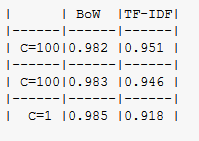

## Linear Support Vector Classification (SVC)

### Linear Support Vector Classification (linearSVC) with Bag of Words

Linear Support Vector Classification (SVC) from sklearn has been chosen over C-Support Vector Classification due to advantage of scalabilty. linear SVC works better with large numbers of samples while C-SVC tend to reach its limit with data sample over 10000 which is teh case in thsi example. The model is implimented with active randomstate and defaut parameters values including a Penalty parameter C =1.
 
The classifier is trained and fit to the data. Next, the model is applied to predit the target value for validation set. 

In [64]:
# LinearSVC classifier defined and trained with training data then used to predit y for training data
LSVC_BoW= LinearSVC(random_state=0)
LSVC_BoW.fit(Xvec_bow_train,y_training)
y_training_pred_LSVCBoW = LSVC_BoW.predict(Xvec_bow_train)

# classifier prediting y for validation data
y_val_pred_LSVCBoW = LSVC_BoW.predict(Xvec_bow_val)

Same as with MultinomialNB classifier, the performance of the model is evaluated  using several performance metrics as defined in the sklearn.metrics package. 
- Confusion or Error Matrix
- Accuracy
- Recall or Sensitivity(True Positive Rate)
- Precision
- F1-Score
- Area under the receiver operating (ROC) curve (AUC)

In [65]:
print("Confusion or Error Matrix with validation set:")
print(confusion_matrix(y_val, y_val_pred_LSVCBoW))
print("\n")

print("Quick calculation of Accuracy of model with training set:")
print(accuracy_score(y_training, y_training_pred_LSVCBoW))
print("\n")

print("Accuracy of model with validation set:")
accuracy_lSVC_BoW= accuracy_score(y_val, y_val_pred_LSVCBoW)
print(accuracy_lSVC_BoW)
print("\n")

print("Recall or Sensitivity(True Positive Rate) with validation set:")
print(recall_score(y_val, y_val_pred_LSVCBoW))
print("\n")

print("Precision with validation set:")
print(precision_score(y_val, y_val_pred_LSVCBoW))
print("\n")

print("F1-Score with validation set:")
F1_lSVC_BoW= f1_score(y_val, y_val_pred_LSVCBoW)
print(F1_lSVC_BoW)
print("\n")

print("Area under the receiver operating (ROC) curve (AUC):")
print(roc_auc_score(y_val, y_val_pred_LSVCBoW))

Confusion or Error Matrix with validation set:
[[3258   82]
 [  60 3445]]


Quick calculation of Accuracy of model with training set:
1.0


Accuracy of model with validation set:
0.979254930606282


Recall or Sensitivity(True Positive Rate) with validation set:
0.9828815977175464


Precision with validation set:
0.9767507796994613


F1-Score with validation set:
0.979806598407281


Area under the receiver operating (ROC) curve (AUC):
0.9791653497569769


In [66]:
print("A summary report of previous measurements with validation set: (1 for spam)")
print(classification_report(y_val, y_val_pred_LSVCBoW, digits=3)) #with validation set

A summary report of previous measurements with validation set: (1 for spam)
             precision    recall  f1-score   support

          0      0.982     0.975     0.979      3340
          1      0.977     0.983     0.980      3505

avg / total      0.979     0.979     0.979      6845



saving using pickle

In [67]:
# Saving classifier as a pickle file 
pickle.dump(LSVC_BoW, open('LSVC_BoW1_model.sav', 'wb'))

### LinearSVC classifier with TF-IDF

This time, the LinearSVC model is trained and fit to the data using TF-IDF feature extracting method using the same parameters tested previousely.

In [68]:
# LinearSVC classifier defined and trained with training data then use dto predit y for training data
LSVC_Tfidf= LinearSVC(random_state=0)
LSVC_Tfidf.fit(Xvec_tfidf_train,y_training)
y_training_pred_tfidf_LSVC = LSVC_Tfidf.predict(Xvec_tfidf_train)

# classifier prediting y for validation data
y_val_pred_LSVCTFIDF = LSVC_Tfidf.predict(Xvec_tfidf_val)

Same as with Bag of Words, the logtic regression classifier is evaluated:
- Confusion or Error Matrix
- Accuracy
- Recall or Sensitivity(True Positive Rate)
- Precision
- F1-Score
- Area under the receiver operating (ROC) curve (AUC)

In [69]:
print("Confusion or Error Matrix with validation set:")
print(confusion_matrix(y_val, y_val_pred_LSVCTFIDF))
print("\n")

print("Quick calculation of Accuracy of model with training set:")
print(accuracy_score(y_training, y_training_pred_tfidf_LSVC))
print("\n")

print("Accuracy of model with validation set:")
print(accuracy_score(y_val, y_val_pred_LSVCTFIDF))
print("\n")

print("Recall or Sensitivity(True Positive Rate) with validation set:")
print(recall_score(y_val, y_val_pred_LSVCTFIDF))
print("\n")

print("Precision with validation set:")
print(precision_score(y_val, y_val_pred_LSVCTFIDF))
print("\n")

print("F1-Score with validation set:")
print(f1_score(y_val, y_val_pred_LSVCTFIDF))
print("\n")

print("Area under the receiver operating (ROC) curve (AUC):")
print(roc_auc_score(y_val, y_val_pred_LSVCTFIDF))

Confusion or Error Matrix with validation set:
[[3102  238]
 [ 120 3385]]


Quick calculation of Accuracy of model with training set:
0.9530914299355455


Accuracy of model with validation set:
0.9476990504017531


Recall or Sensitivity(True Positive Rate) with validation set:
0.9657631954350927


Precision with validation set:
0.9343085840463704


F1-Score with validation set:
0.9497755331088665


Area under the receiver operating (ROC) curve (AUC):
0.9472528552025763


In [70]:
print("A summary report of previous measurements with validation set: (1 for spam)")
print(classification_report(y_val, y_val_pred_LSVCTFIDF)) #with validation set

A summary report of previous measurements with validation set: (1 for spam)
             precision    recall  f1-score   support

          0       0.96      0.93      0.95      3340
          1       0.93      0.97      0.95      3505

avg / total       0.95      0.95      0.95      6845



In [71]:
# Saving classifier as a pickle file 
joblib.dump(LSVC_Tfidf, 'LSVCtfidf_model1.pkl') 

['LSVCtfidf_model1.pkl']

## k-nearest neighbors 

The last Classifier that will be investigate din this exercice is the k-nearest neighbors Classifier which implemente the k-nearest neighbors vote. k-nearest neighbors from sklearn will be used with default parameters including k=5 and metric =‘minkowski’

### k-nearest neighbors with Bag of words

k-nearest neighbors classifier (feature extraction using Bag of words) is trained and fit to the data. Next, the model is applied to predit the target value for validation set.

In [72]:
# k-nearest neighbors  classifier defined and trained with training data then used to predit y for training data
kNN_BoW= KNeighborsClassifier()
kNN_BoW.fit(Xvec_bow_train,y_training)
y_training_pred_kNNBoW = kNN_BoW.predict(Xvec_bow_train)

# classifier prediting y for validation data
y_val_pred_kNNBoW = kNN_BoW.predict(Xvec_bow_val)

Same as with other classifiers, the performance of the model is evaluated  using several performance metrics as defined in the sklearn.metrics package. 
- Confusion or Error Matrix
- Accuracy
- Recall or Sensitivity(True Positive Rate)
- Precision
- F1-Score
- Area under the receiver operating (ROC) curve (AUC)

In [73]:
print("Confusion or Error Matrix with validation set:")
print(confusion_matrix(y_val, y_val_pred_kNNBoW))
print("\n")

print("Quick calculation of Accuracy of model with training set:")
print(accuracy_score(y_training, y_training_pred_kNNBoW))
print("\n")

print("Accuracy of model with validation set:")
print(accuracy_score(y_val, y_val_pred_kNNBoW))
print("\n")

print("Recall or Sensitivity(True Positive Rate) with validation set:")
print(recall_score(y_val, y_val_pred_kNNBoW))
print("\n")

print("Precision with validation set:")
print(precision_score(y_val, y_val_pred_kNNBoW))
print("\n")

print("F1-Score with validation set:")
print(f1_score(y_val, y_val_pred_kNNBoW))
print("\n")

print("Area under the receiver operating (ROC) curve (AUC):")
print(roc_auc_score(y_val, y_val_pred_kNNBoW))

Confusion or Error Matrix with validation set:
[[2441  899]
 [  87 3418]]


Quick calculation of Accuracy of model with training set:
0.8900095488183337


Accuracy of model with validation set:
0.8559532505478451


Recall or Sensitivity(True Positive Rate) with validation set:
0.9751783166904422


Precision with validation set:
0.7917535325457493


F1-Score with validation set:
0.8739452825364357


Area under the receiver operating (ROC) curve (AUC):
0.8530083200218677


In [74]:
print("A summary report of previous measurements with validation set: (1 for spam)")
print(classification_report(y_val, y_val_pred_kNNBoW, digits=3)) #with validation set

A summary report of previous measurements with validation set: (1 for spam)
             precision    recall  f1-score   support

          0      0.966     0.731     0.832      3340
          1      0.792     0.975     0.874      3505

avg / total      0.877     0.856     0.853      6845



saving using pickle

In [75]:
# Saving classifier as a pickle file 
pickle.dump(kNN_BoW, open('MkNN_BoW1_model.sav', 'wb'))

<b> 6.2 k-nearest neighbors with TF-IDF

This time, the Logistic regression model is trained and fit to the data using TF-IDF feature extracting method using the same parameters tested previousely. Next, the model is applied to predit the target value for validation set

In [76]:
# k-nearest neighbors classifier defined and trained with training data then use dto predit y for training data
kNN_Tfidf= KNeighborsClassifier()
kNN_Tfidf.fit(Xvec_tfidf_train,y_training)
y_training_pred_tfidf_kNN = kNN_Tfidf.predict(Xvec_tfidf_train)

# classifier prediting y for validation data
y_val_pred_kNNTFIDF = kNN_Tfidf.predict(Xvec_tfidf_val)

In [77]:
print("Confusion or Error Matrix with validation set:")
print(confusion_matrix(y_val, y_val_pred_kNNTFIDF))
print("\n")

print("Quick calculation of Accuracy of model with training set:")
print(accuracy_score(y_training, y_training_pred_tfidf_kNN))
print("\n")

print("Accuracy of model with validation set:")
accuracy_kNN_TFIDF= accuracy_score(y_val, y_val_pred_kNNTFIDF)
print(accuracy_kNN_TFIDF)
print("\n")

print("Recall or Sensitivity(True Positive Rate) with validation set:")
print(recall_score(y_val, y_val_pred_kNNTFIDF))
print("\n")

print("Precision with validation set:")
print(precision_score(y_val, y_val_pred_kNNTFIDF))
print("\n")

print("F1-Score with validation set:")
F1_kNN_TFIDF=f1_score(y_val, y_val_pred_kNNTFIDF)
print(F1_kNN_TFIDF)
print("\n")

print("Area under the receiver operating (ROC) curve (AUC):")
print(roc_auc_score(y_val, y_val_pred_kNNTFIDF))

Confusion or Error Matrix with validation set:
[[2983  357]
 [ 405 3100]]


Quick calculation of Accuracy of model with training set:
0.9265934590594413


Accuracy of model with validation set:
0.8886778670562454


Recall or Sensitivity(True Positive Rate) with validation set:
0.884450784593438


Precision with validation set:
0.8967312698871854


F1-Score with validation set:
0.8905486929043379


Area under the receiver operating (ROC) curve (AUC):
0.8887822785242638


In [78]:
print("A summary report of previous measurements with validation set: (1 for spam)")
print(classification_report(y_val, y_val_pred_kNNTFIDF)) #with validation set

A summary report of previous measurements with validation set: (1 for spam)
             precision    recall  f1-score   support

          0       0.88      0.89      0.89      3340
          1       0.90      0.88      0.89      3505

avg / total       0.89      0.89      0.89      6845



In [79]:
# Saving classifier as a pickle file 
joblib.dump(kNN_Tfidf, 'kNNtfidf_model1.pkl') 
pickle.dump(kNN_Tfidf, open('kNNtfidf_model1.sav', 'wb'))

## Model selection

The results of the previousely investigated, trained and evaluated Classifiers will be compared with the purpose of selecting a model for final evaluaion and testing with test set. The Classifiers that will be compared are the following:
- Multinomial Naive Bayes classifier with Bag of words
- Logistic regression classifier (C=1)with Bag of words 
- Linear Support Vector Classification with Bag of Words
- k-nearest neighbors with TF-IDF 

The comparison will consist in comparing accuracy and F1-score values of respective Calssifiers:
- for selected Multinomial Naive Bayes: 
accuracy_Multi_BoW and F1_Multi_BoW
- for selected Logistic regression: 
accuracy_Lreg_BoW and F1_Lreg_BoW
- for selected Linear Support Vector Classification: 
accuracy_lSVC_BoW and F1_lSVC_BoW
- for selected k-nearest neighbors: 
accuracy_kNN_TFIDF and F1_kNN_TFIDF


In [80]:
classifiers= pd.Series(['Multinomial Naive Bayes','Logistic Regression','Linear Support Vector','k-Nearest Neighbors'],
                       index= range(4))
Accuracy_score= pd.Series([accuracy_Multi_BoW, accuracy_Lreg_BoW, accuracy_lSVC_BoW, accuracy_kNN_TFIDF],index= range(4))
F1_score= pd.Series([F1_Multi_BoW, F1_Lreg_BoW, F1_lSVC_BoW, F1_kNN_TFIDF], index= range(4))


compare_classifiers= pd.DataFrame({'Classifiers': classifiers, 'Accuracy score': Accuracy_score,'F1 score':F1_score })


In [81]:
compare_classifiers

,Classifiers,Accuracy score,F1 score
0,Multinomial Naive Bayes,0.988313,0.988604
1,Logistic Regression,0.986998,0.987378
2,Linear Support Vector,0.979255,0.979807
3,k-Nearest Neighbors,0.888678,0.890549


Multinomial Naive Bayes and Logistic Regression are presenting very similar results with an accuracy at 98%.

<br>
Plotting some graphs to compare classifiers.

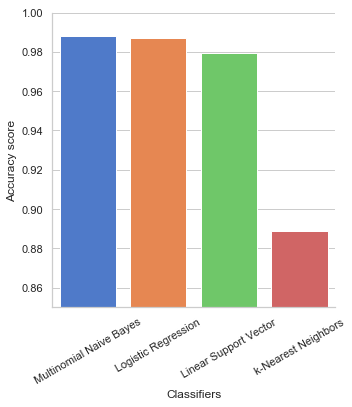

In [82]:
sns.set(context='notebook', style='whitegrid')
figsize=(16,12)
ax= sns.catplot(x='Classifiers', palette= "muted",saturation= 0.9, y='Accuracy score', kind="bar"
                ,data=compare_classifiers)
ax.set_xticklabels(rotation=30)
ax.set(ylim=(0.85, 1))

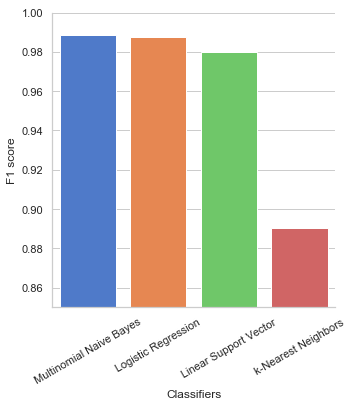

In [83]:
sns.set(context='notebook', style='whitegrid')
figsize=(16,12)
ax= sns.catplot(x='Classifiers', palette= "muted",saturation= 0.9, y='F1 score', kind="bar"
                ,data=compare_classifiers)
ax.set_xticklabels(rotation=30)
ax.set(ylim=(0.85, 1))

Looking at both figures abive and as expected, Multinomial Naive Bayes classified is the classifier with the best performance

# Model evaluation

Multinomial Naive Bayes Classifier developped with Bag of words vectorizer has been selected as the best performing module and thus will be used to evaluate it with out-of-sample dataset, i.e testing set.
<br>

Initial step of this process ise to apply all cleaning process that was developped with training set to Test set.
Fowlloing this cleaning process, selected Naive Bayes Clssifier will be applied to test data and from there performance of the classified with test set will be evaluated

## Cleansing of test dataset

In [84]:
# variables of test dataset test_set, X_test and y_test 

X_test_lemmatized = X_test.apply(lemmatize_email)

X_test_processed= X_test_lemmatized.apply(lambda x: ' '.join([word for word in x if word.lower() not in (stop_word)]))

## Running Multinomial Naive Bayes Classifier with test dataset

Loading and applying teh selected Multinomial Naive Bayes Classifier to Test dataset.

In [86]:
# load the model from disk
loaded_model = joblib.load(open('Multi_BoW_model.pkl', 'rb'))
#result = loaded_model.score(X_test_processed, y_test)

In [87]:
# Bag of words vectorizer fit to test data and classifier prediting y for test data
Xvec_bow_test= BoW_vectorizer.transform(X_test_processed)
y_test_pred_MultiBoW = Multi_BoW.predict(Xvec_bow_test)

Next step consists in evaluating performance of this MultinomialNB classifier using same performance metrics as defined before but this time with test dataset.
- Confusion or Error Matrix
- Accuracy
- Recall or Sensitivity(True Positive Rate)
- Precision
- F1-Score
- Area under the receiver operating (ROC) curve (AUC)

In [88]:
print("Confusion or Error Matrix with test set:")
print(confusion_matrix(y_test, y_test_pred_MultiBoW))
print("\n")

print("Accuracy of model with test set:")
accuracy_Multi_BoW=accuracy_score(y_test, y_test_pred_MultiBoW)
print(accuracy_Multi_BoW)
print("\n")

print("Recall or Sensitivity(True Positive Rate) with test set:")
print(recall_score(y_test, y_test_pred_MultiBoW))
print("\n")

print("Precision with test set:")
print(precision_score(y_test, y_test_pred_MultiBoW))
print("\n")

print("F1-Score with testset:")
F1_Multi_BoW=f1_score(y_test, y_test_pred_MultiBoW)
print(F1_Multi_BoW)
print("\n")

print("test set: Area under the receiver operating (ROC) curve (AUC):")
print(roc_auc_score(y_test, y_test_pred_MultiBoW))

Confusion or Error Matrix with test set:
[[4913   60]
 [  50 5092]]


Accuracy of model with test set:
0.9891250617894216


Recall or Sensitivity(True Positive Rate) with test set:
0.9902761571373007


Precision with test set:
0.9883540372670807


F1-Score with testset:
0.9893141635904411


test set: Area under the receiver operating (ROC) curve (AUC):
0.9891055026587368


In [89]:
print("A summary report of previous measurements with test set: (1 for spam)")
print(classification_report(y_test, y_test_pred_MultiBoW, digits=3)) #with validation set

A summary report of previous measurements with test set: (1 for spam)
             precision    recall  f1-score   support

          0      0.990     0.988     0.989      4973
          1      0.988     0.990     0.989      5142

avg / total      0.989     0.989     0.989     10115



Looking at these results with this selected Multinomial Naive Bayes Classifier, absolute accuracy (accuracy with test dataset) was about 98.9%. All performance metrics are also high confirming that Multinomial Naive Bayes Classifier is the best classifier for this dataset. This is in accordance with the results obtained in the original publication *(V. Metsis et al. "Spam Filtering with Naive Bayes - Which Naive Bayes?". CEAS 2006, Mountain View, CA, USA, 2006)*. In general, it has been observed in many publications that Multinomial Naive Bayes Classifier is usually performing well with binary classification and it's not surprise that it is always investigated for email classifications projects.

# Conclusion 
To sum up, the process of building up a pipeline and a model of classification for Enron emails dataset consisted in quite laborious pre-processing step, where cleaning and tokenizing dataset was of very importance. Once the data was cleansed and prepared for modelling, the process was to apply various supervision classifiers while tuning some of their parameters. At the end, and as was reported in previous publications, Multinomial Naive Bayes Classifier provided the best results with Training, Validation and Test data subset.
Another interesting observation, Bag of Words approach for feature extraction performed better than TF-IDF vectorization. This could be due to the further complication and over-modelling that could TF-IDF bring.
It was observed also that kNN classifier was the higher consumer in term of computing and memory resources neither less the performance of this classifier was quite lower than the best performing classifiers.
To conclude, the selected classifier- Multinomial Naive Bayes Classifier using Bag of Words technique- gave ideal performance results when tested with Test dataset with an **accuracy approaching 99%.**


# References

<a href="https://seaborn.pydata.org/generated/seaborn.catplot.html">seaborn.catplot</a>

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html">KNeighborsClassifier</a>

<a href="https://github.com/amueller/word_cloud">word_cloud</a>

<a href="https://medium.com/data-from-the-trenches/text-classification-the-first-step-toward-nlp-mastery-f5f95d525d73">Text Classification: The First Step Toward NLP Mastery</a>

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html">TfidfVectorizer</a>

V. Metsis, I. Androutsopoulos and G. Paliouras, (2006) Spam Filtering with Naive Bayes - Which Naive Bayes?". Proceedings of the 3rd Conference on Email and Anti-Spam.CEAS 2006, Mountain View, CA, USA, 2006.
<br>

W.A, Awad & S.M, ELseuofi. (2011). Machine Learning methods for E-mail Classification. International Journal of Computer Applications. 16. 10.5120/1974-2646.
<br>

Raschka, S. (2014). Python Machine Learning. 1st ed. Birmingham B3 2PB, UK.: Packt Publishing Ltd.